In [ ]:
# !pip install selenium
# !pip install pymongo
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install matplotlib
# !pip install BeautifulSoup
# !pip install python-dotenv pymongo dnspython
#!pip install wordcloud
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from pymongo import MongoClient
from datetime import datetime
import time
import re
import os
from bs4 import BeautifulSoup
from dotenv import load_dotenv

In [ ]:
# Please check README.md first

'''
URL='https://nofluffjobs.com/api/search/posting?withSalaryMatch=true&pageTo=2&pageSize=20&salaryCurrency=PLN&salaryPeriod=month&region=pl&language=en-GB'
If we use request.post(url，payload)
Is's easier to get more details from one query
'''

# load environment variable to init db
load_dotenv()


# HTML webpage scrapping
class WebScrapingNoFluff:
    def __init__(self, query_term='backend'):
        print('Initialise WebScraping instance')
        self.query_term = query_term
        self.target_url = f"https://nofluffjobs.com/pl/?lang=en&criteria=jobPosition%3D{self.query_term}"
        self.final_html = ''
        # --- init db: local db / Atlas Mongodb ---
        self._init_db()

    def _init_db(self):
        """
        You don't need .env, cause you will deploy on local db
        MONGO_MODE from .env:
        "local": connect with local mongodb
        "atlas": connect with remote mongodb
        """

        mode = os.getenv("MONGO_MODE", "local")
        db_name = os.getenv("DB_NAME", "BD_final")

        print("DB MODE: ", mode)

        if mode == "atlas":
            uri = os.getenv("ATLAS_MONGO_URI")
            if not uri:
                raise ValueError("❌ Error: ATLAS_MONGO_URI not found in .env while mode is 'atlas'")
            print(f"🌐 Connecting to Remote MongoDB Atlas...")
        else:
            uri = "mongodb://localhost:27017/"
            print(f" Connecting to Local MongoDB ({uri})...")

        try:
            self.client = MongoClient(uri)
            # test connection
            self.client.admin.command('ping')
            self.db = self.client[db_name]
            print(f"✅ Successfully connected to database: {db_name}")
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise

    def scrape_save_raw_to_db(self, clicks=3):
        driver = webdriver.Chrome()
        driver.get(self.target_url)
        driver.maximize_window()
        # Give you 15 seconds to accept/cancel all popup window
        wait = WebDriverWait(driver, 15)

        # Loop to click "See more offers" button 10 times
        count = 0
        while count < clicks:
            try:
                # Find the button with the nfjloadmore attribute
                load_more_btn = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[nfjloadmore]")))

                # Scroll to the button position to ensure it is in the viewport
                driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", load_more_btn)
                time.sleep(1.5)  # Allow some buffer time for scrolling

                # Click to load more
                if load_more_btn:
                    load_more_btn.click()
                count += 1
                print(f"Clicked 'See more' ({count}/{clicks})")

                # Delay for new content to load
                time.sleep(2.5)
            except Exception as e:
                print(f"Finished loading or button not found: {e}")
                break

        # C. Get the complete HTML after 10 clicks and save it
        print("All pages loaded. Capturing final HTML...")
        self.final_html = driver.page_source
        self.save_raw_to_mongodb()

        driver.quit()

    def save_raw_to_mongodb(self):
        """
        Reference your initial logic to store the raw HTML into NoSQL
        """
        # only hold one raw_json html data
        self.db.jobs_raw.drop()
        website_document = {
            'url': self.target_url,
            'content': self.final_html,
            'date': datetime.now(),
            'query_term': self.query_term
        }

        # Store in the jobs_raw collection
        result = self.db.jobs_raw.insert_one(website_document)
        print(f"Raw HTML saved to MongoDB! Document ID: {result.inserted_id}")

    # parse and split salary to min and max two value
    def parse_salary(self, salary_str):
        """
        Internal helper method: Parse salary string
        Example input: "10 000 - 15 000 PLN", "20 000 PLN", "Undisclosed"
        Output: (min_salary, max_salary)
        """
        if not salary_str or "Undisclosed" in salary_str or "Agreement" in salary_str:
            return None, None

        # Remove spaces and thousands separators
        clean_str = salary_str.replace('\xa0', '').replace(' ', '')

        # Match all digits
        numbers = re.findall(r'\d+', clean_str)

        try:
            if len(numbers) >= 2:
                # Range salary: [10000, 15000]
                return float(numbers[0]), float(numbers[1])
            elif len(numbers) == 1:
                # Fixed salary: [20000]
                return float(numbers[0]), float(numbers[0])
        except Exception:
            pass

        return None, None

    # parse job location
    def parse_location(self, card):
        """
        Internal helper method: Parse location
        """
        location_tag = card.select_one('span.posting-info__location, nfj-posting-item-city')
        if not location_tag:
            return "Unknown"

        loc_text = location_tag.get_text(strip=True)

        # Special case handling: Remote work
        if "Remote" in loc_text or "Zdalna" in loc_text:
            return "Remote"

        # Extract city name (some include '+1', filter via split)
        city = loc_text.split('+')[0].strip()
        return city

    # parse job title,company name, Min/Max Salary,Location, Jump URL and save into db
    def process_and_save(self):
        """
        Read HTML from jobs_raw and extract fields to store in jobs_processed
        extract raw html and parse fields then save into
        """
        # Get the most recently scraped HTML document
        raw_data = self.db.jobs_raw.find_one(sort=[("date", -1)])
        if not raw_data:
            print("No raw data found in MongoDB!")
            return

        soup = BeautifulSoup(raw_data['content'], 'html.parser')

        # Locate all job cards
        postings = soup.select('a.posting-list-item')
        print(f"Found {len(postings)} job postings in HTML.")

        processed_list = []
        base_domain = "https://nofluffjobs.com"  # Used to concatenate the full URL

        for post in postings:
            try:
                # --- Field 1: Job Title ---
                title_el = post.select_one('h3.posting-title__position, .posting-title__can-hide')
                if title_el:
                    # Find and remove any potential "NEW" tags or other badges
                    # NFJ's badge class names usually contain title-badge
                    for badge in title_el.select('.title-badge, .title-badge--new'):
                        badge.decompose()
                    job_title = title_el.get_text(strip=True)
                else:
                    job_title = "N/A"
                # print('JOB TITLE:', job_title)

                # --- Field 2: Company Name ---
                company_el = post.select_one('span.d-block, .company-name')
                company_name = company_el.get_text(strip=True) if company_el else "N/A"

                # --- Fields 3 & 4: Min/Max Salary ---
                salary_el = post.select_one('span.text-truncate, nfj-posting-item-salary')
                salary_str = salary_el.get_text(strip=True) if salary_el else ""
                min_sal, max_sal = self.parse_salary(salary_str)

                # --- Field 5: Location ---
                location = self.parse_location(post)

                # --- Field 6: Jump URL ---
                # Get relative path from the <a> tag's href attribute and concatenate domain
                relative_url = post.get('href')
                jump_url = base_domain + relative_url if relative_url else "N/A"

                # Construct document
                job_doc = {
                    "source": "nofluffjobs",
                    'job_title': job_title,
                    'company_name': company_name,
                    'min_salary': min_sal,
                    'max_salary': max_sal,
                    'location': location,
                    'jump_url': jump_url,  # Add to the document
                    'processed_at': datetime.now(),
                    'query_term': raw_data['query_term']
                }

                processed_list.append(job_doc)

            except Exception as e:
                print(f"Error parsing a single post: {e}")
                continue

        # Batch save to the new collection
        if processed_list:
            self.db.jobs_processed.drop()
            self.db.jobs_processed.insert_many(processed_list)
            print(f"Successfully processed {len(processed_list)} jobs and saved to 'jobs_processed'.")

    # scrape the job detail page and add must-have skill set into each job
    def scrape_must_have_skills(self, limit=0):
        driver = webdriver.Chrome()
        driver.maximize_window()
        wait = WebDriverWait(driver, 15)

        jobs = list(self.db.jobs_processed.find().limit(limit))
        print(f"Scraping Must-have skills for {len(jobs)} jobs")

        for job in jobs:
            url = job.get("jump_url")
            if not url:
                continue

            try:
                driver.get(url)
                time.sleep(2)  # wait for page to render

                soup = BeautifulSoup(driver.page_source, "html.parser")
                must_section = soup.select_one('section[branch="musts"]')

                skills = []
                if must_section:
                    skill_tags = must_section.select('span[id^="item-tag-"]')
                    for tag in skill_tags:
                        skills.append(tag.get_text(strip=True).lower())

                # Update MongoDB document
                self.db.jobs_processed.update_one(
                    {"_id": job["_id"]},
                    {"$set": {"must_have_skills": skills}}
                )

                print(f"✔ {job['job_title']} → {skills}")

            except Exception as e:
                print(f"❌ Error scraping {url} : {e}")

        driver.quit()
        print("Finished scraping Must-have skills.")

In [ ]:
# 1.run the WebScrapper
# 2.query and save the raw html data into mongodb
scraperNoFluff = WebScrapingNoFluff(query_term='backend')
scraperNoFluff.scrape_save_raw_to_db()

In [ ]:
# 3.extract data, and parse the job list html into fields and save into db again
scraperNoFluff.process_and_save()

In [ ]:
# 4.More details, Scrape Must-have skills from each job page
scraperNoFluff.scrape_must_have_skills()

In [ ]:
# http api scrapping
class WebScrapingJustJoin:
    def __init__(self, query_term="backend"):
        print("Initialise WebScrapingJustJoin instance")
        self.query_term = query_term
        self.api_url = (
            "https://api.justjoin.it/v2/user-panel/offers/by-cursor"
            "?cityRadiusKm=30"
            "&currency=pln"
            "&from=0"
            "&itemsCount=100"
            f"&keywords[]={query_term.replace(' ', '%20')}"
            "&orderBy=DESC"
            "&sortBy=published"
        )
        self._init_db()

    def _init_db(self):
        mode = os.getenv("MONGO_MODE", "local")
        db_name = os.getenv("DB_NAME", "BD_final")

        if mode == "atlas":
            uri = os.getenv("ATLAS_MONGO_URI")
        else:
            uri = "mongodb://localhost:27017/"

        self.client = MongoClient(uri)
        self.db = self.client[db_name]
        print("✅ JustJoin connected to DB")

    # ---- salary normalization (matches NoFluff logic) ----
    def normalize_salary(self, emp):
        if not emp or emp.get("from") is None:
            return None, None

        from_sal = emp.get("from")
        to_sal = emp.get("to")
        unit = emp.get("unit")  # hour / day / month

        if unit == "hour":
            return from_sal * 160, to_sal * 160
        if unit == "day":
            return from_sal * 20, to_sal * 20

        return from_sal, to_sal  # month

    def scrape_and_process(self):
        import requests

        response = requests.get(self.api_url)
        raw = response.json()

        processed = []

        for job in raw.get("data", []):
            emp = job.get("employmentTypes", [{}])[0]
            min_sal, max_sal = self.normalize_salary(emp)

            processed.append({
                "source": "justjoin",
                "job_title": job.get("title"),
                "company_name": job.get("companyName"),
                "min_salary": min_sal,
                "max_salary": max_sal,
                "location": job.get("city"),
                "jump_url": f"https://justjoin.it/offers/{job.get('slug')}",
                "must_have_skills": [
                    skill.lower() for skill in job.get("requiredSkills", [])
                ],
                "processed_at": datetime.now(),
                "query_term": self.query_term
            })

        self.db.jobs_processed_jj.drop()
        self.db.jobs_processed_jj.insert_many(processed)
        print(f"✅ Saved {len(processed)} JustJoin jobs")


In [ ]:
# 6️⃣ Scrape JustJoin.it jobs 
jj_scraper = WebScrapingJustJoin(query_term="backend")
jj_scraper.scrape_and_process()

DB MODE:  atlas
🌐 Connecting to Remote MongoDB Atlas...
✅ Successfully connected to database: BD_final
Mean Absolute Error: 6675.53
R² Score: -0.12


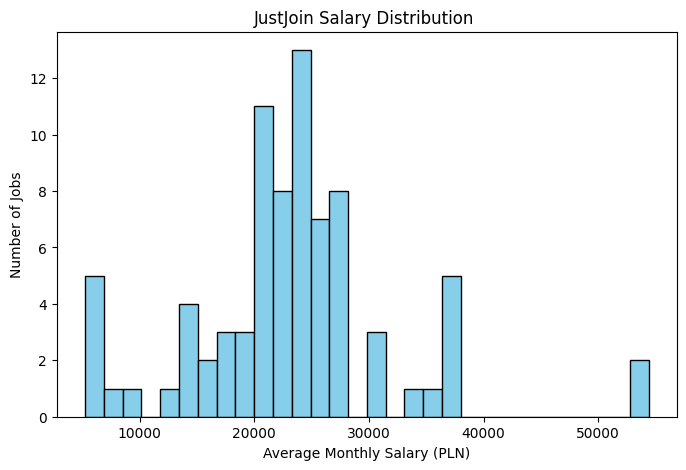

<Figure size 800x500 with 0 Axes>

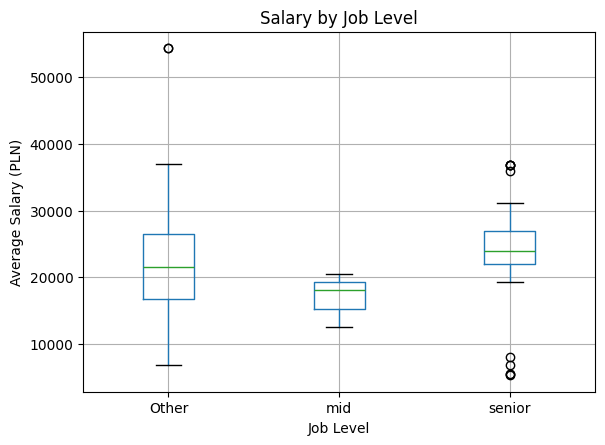

<Figure size 800x500 with 0 Axes>

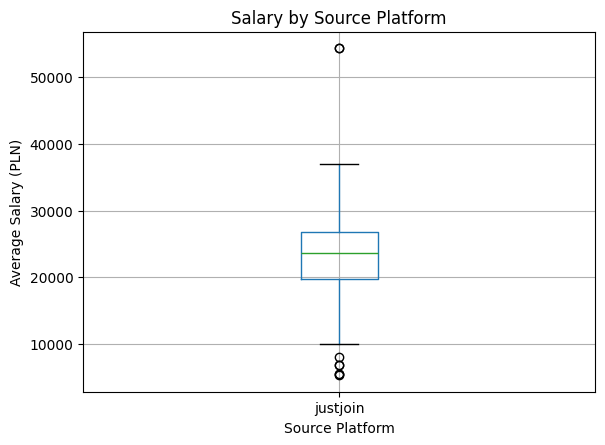

Mean Absolute Error: 5881.63
R² Score: 0.12


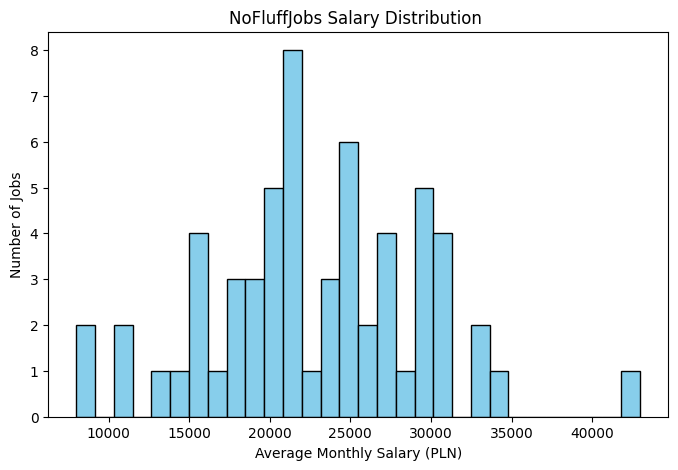

<Figure size 800x500 with 0 Axes>

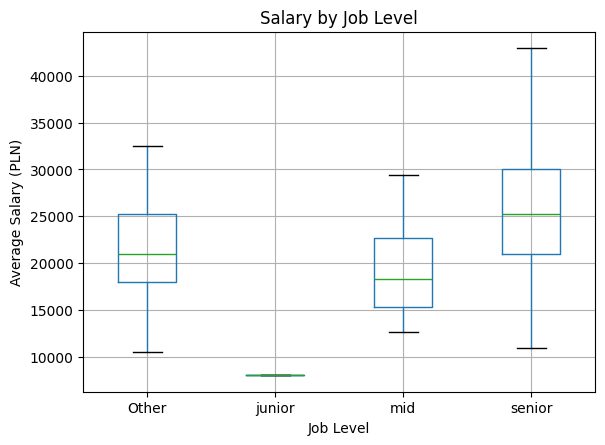

<Figure size 800x500 with 0 Axes>

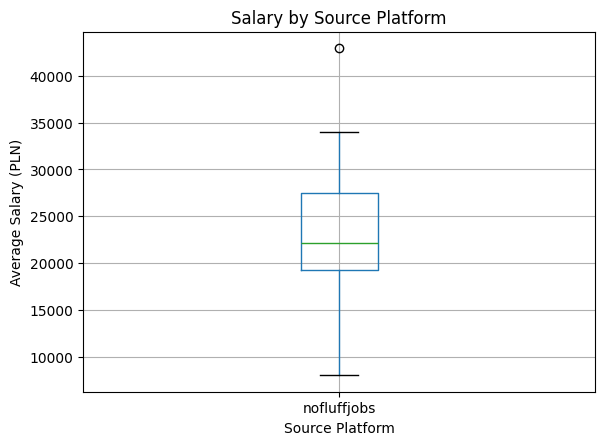

In [6]:
# Train model and visualization except must_have_skills
# -------------------------
# 1️⃣ Import libraries
# -------------------------

import pandas as pd
import numpy as np
from pymongo import MongoClient
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from dotenv import load_dotenv

load_dotenv()


# Run this function to make sure we can query data from Mongodb Atlas and local DB
def init_db():
    mode = os.getenv("MONGO_MODE", "local")
    db_name = os.getenv("DB_NAME", "BD_final")

    print("DB MODE: ", mode)

    if mode == "atlas":
        uri = os.getenv("ATLAS_MONGO_URI")
        if not uri:
            raise ValueError("❌ Error: ATLAS_MONGO_URI not found in .env while mode is 'atlas'")
        print(f"🌐 Connecting to Remote MongoDB Atlas...")
    else:
        uri = "mongodb://localhost:27017/"
        print(f" Connecting to Local MongoDB ({uri})...")

    try:
        my_client = MongoClient(uri)
        # test connection
        my_client.admin.command('ping')
        my_db = my_client[db_name]
        print(f"✅ Successfully connected to database: {db_name}")
        return my_db
    except Exception as e:
        print(f"❌ Database connection failed: {e}")
        raise


# Initialized DB
db = init_db()

# function train_and_visualise(platform_name), platform_name = JUST_JOIN / NO_FLUFF_JOBS
from enum import Enum

class CollectionEnum(Enum):
    JUST_JOIN = "JustJoin"
    NO_FLUFF_JOBS = "NoFluffJobs"


def job_level(title):
    title = title.lower()
    if "senior" in title:
        return "senior"
    if "junior" in title:
        return "junior"
    if "mid" in title or "regular" in title:
        return "mid"
    return "Other"


def train_and_visualise(platform_name):
    if platform_name == CollectionEnum.JUST_JOIN:
        data = list(db.jobs_processed_jj.find())
    elif platform_name == CollectionEnum.NO_FLUFF_JOBS:
        data = list(db.jobs_processed.find())
    else:
        raise NameError("Can not find the correct collection name")

    # -------------------------
    # 2️⃣ Load data from MongoDB
    # -------------------------
    df = pd.DataFrame(data)

    # Keep only relevant columns that exist
    df = df[[
        "source",
        "job_title",
        "company_name",
        "min_salary",
        "max_salary",
        "location"
    ]]

    # Drop rows without salary
    df = df.dropna(subset=["min_salary", "max_salary"])

    # Target variable: average salary
    df["avg_salary"] = (df["min_salary"] + df["max_salary"]) / 2

    # -------------------------
    # 3️⃣ Feature engineering
    # -------------------------
    # Extract job level from job title

    df["job_level"] = df["job_title"].apply(job_level)

    # Features and target
    X = df[["location", "source", "job_level"]]
    y = df["avg_salary"]

    # -------------------------
    # 4️⃣ Encode categorical + train model
    # -------------------------
    categorical_features = ["location", "source", "job_level"]

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    model.fit(X_train, y_train)

    # -------------------------
    # 5️⃣ Evaluate model
    # -------------------------
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

    # -------------------------
    # 6️⃣ Visualization
    # -------------------------

    # Salary distribution
    plt.figure(figsize=(8, 5))
    plt.hist(df["avg_salary"], bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("Average Monthly Salary (PLN)")
    plt.ylabel("Number of Jobs")
    plt.title(platform_name.value + " Salary Distribution ")
    plt.show()

    # Salary by job level
    plt.figure(figsize=(8, 5))
    df.boxplot(column="avg_salary", by="job_level")
    plt.xlabel("Job Level")
    plt.ylabel("Average Salary (PLN)")
    plt.title("Salary by Job Level")
    plt.suptitle("")  # remove default title
    plt.show()

    # Salary by source platform
    plt.figure(figsize=(8, 5))
    df.boxplot(column="avg_salary", by="source")
    plt.xlabel("Source Platform")
    plt.ylabel("Average Salary (PLN)")
    plt.title("Salary by Source Platform")
    plt.suptitle("")
    plt.show()


train_and_visualise(CollectionEnum.JUST_JOIN)
train_and_visualise(CollectionEnum.NO_FLUFF_JOBS)


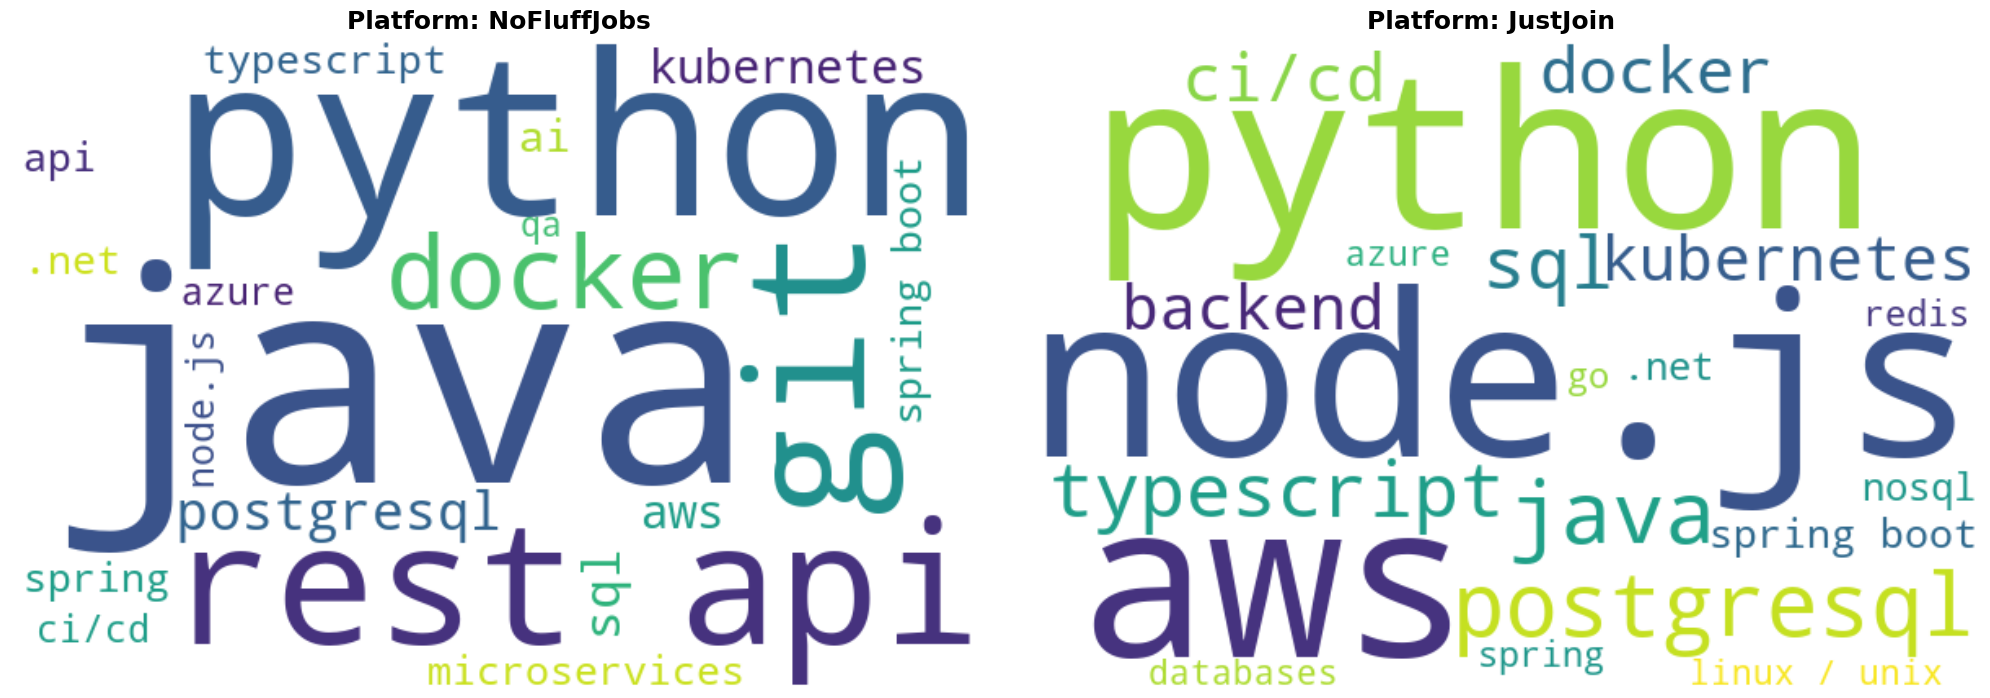

In [7]:
from wordcloud import WordCloud
from collections import Counter

def visualize_by_word_cloud(platform_name, ax, number_of_words_visible=20):
    """
    Fetches job data from MongoDB, processes 'must_have_skills',
    and generates a word cloud on the provided axis.
    """
    # Load data
    if platform_name == CollectionEnum.JUST_JOIN:
        data = list(db.jobs_processed_jj.find())
    elif platform_name == CollectionEnum.NO_FLUFF_JOBS:
        data = list(db.jobs_processed.find())
    else:
        raise NameError("Cannot find the correct collection name")

    df = pd.DataFrame(data)

    # Identify skill columns containing the keyword 'must_have_skills'
    skill_cols = [col for col in df.columns if 'must_have_skills' in col]
    raw_skills = df[skill_cols].values.flatten()


    all_skills = []
    for item in raw_skills:

        if isinstance(item, (list, np.ndarray)):
            for s in item:
                if pd.notna(s) and str(s).strip() != '':
                    all_skills.append(str(s).strip().lower())
        # Handle single string values
        elif pd.notna(item) and str(item).strip() != '':
            all_skills.append(str(item).strip().lower())


    skill_counts = Counter(all_skills)


    wc = WordCloud(
        width=600,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=number_of_words_visible
    ).generate_from_frequencies(skill_counts)


    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Platform: {platform_name.value}", fontsize=18, fontweight='bold')
    ax.axis('off')



# Create a figure with 1 row and 2 columns for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


visualize_by_word_cloud(CollectionEnum.NO_FLUFF_JOBS, ax=ax1)
visualize_by_word_cloud(CollectionEnum.JUST_JOIN, ax=ax2)


plt.tight_layout()


plt.savefig('combined_skills_comparison.png')


plt.show()
